In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [6]:
diamonds_df = pd.read_csv('diamonds.csv')

In [7]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


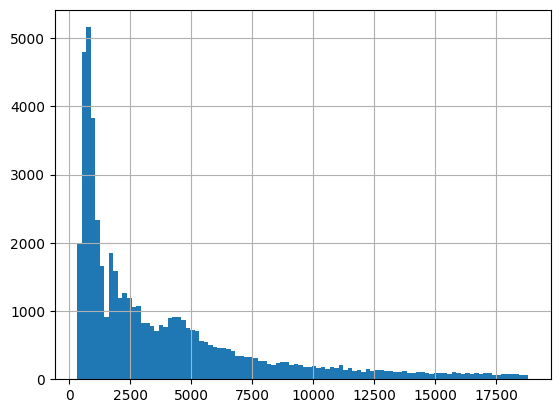

In [8]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [9]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [10]:
print([1,2])

[1, 2]


In [11]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [12]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [147]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,4,1,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,3,5,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,1,6,1,63.3,58.0,335,4.34,4.35,2.75


In [13]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [14]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [16]:
reg = LinearRegression().fit(X_train, y_train)

In [17]:
y_pred = reg.predict(X_test)

In [18]:
score = r2_score(y_pred, y_test)

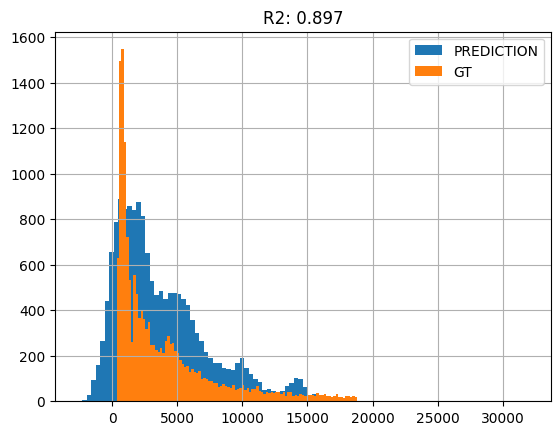

In [19]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [702]:
class SigmoidLayer:
    def __init__(self) -> None:
        pass
    def forward(self,X):
        self.y = 1/(1 + np.exp(-X))
        return self.y
    def backward(self,dLdy):
        return dLdy * self.y * (1 - self.y)
    def step(self):
        pass

In [703]:
class LinearLayer:
    def __init__(self, input_size,output_size,l_r):
        self.W = np.ones((input_size,output_size)) * 0.01
        self.b = np.ones((output_size)) * 0.01
        self.l_r = l_r
        
    
    def forward(self, X):
        self.X = X
        #print(X.shape, self.W.shape)
        self.Y = X @ self.W + self.b
        return self.Y
    
    def backward(self, dLdy):
        dydw = self.W
        self.dLdw = np.expand_dims(self.X, -1) * np.expand_dims(dLdy, -2) # Because it is 3D matrix
        self.dLdb = dLdy # as dy/db == 1
          
        if len(self.dLdw.shape) > 2:
            self.dLdw = self.dLdw.sum(axis=0)
        if len(self.dLdb) > 2:
             self.dLdb = self.dLdb.sum(axis=0)
        
        dLdx = dLdy @ self.W.T
        return dLdx
    def step(self):
        self.W -= self.dLdw * self.l_r
        self.b -= self.dLdb * self.l_r

In [783]:
def check_gradient(f,x,eps = 1e-6):
    y = np.ones(x.shape)
    for i in range(x.shape[0]):
            if (len(x.shape) > 1):
                for j in range(x.shape[1]):
                    x[i,j] += eps
                    f_plus = f(x)
                    x[i][j] -= 2 * eps
                    f_minus = f(x)
                    x[i][j] += eps

                    y[i][j] = (f_plus - f_minus) / (2 * eps)
            else:
                    x[i] += eps
                    f_plus = f(x)
                    x[i] -= 2 * eps
                    f_minus = f(x)
                    x[i] += eps

                    y[i] = (f_plus - f_minus) / (2 * eps)
    return y

test_x = np.array([1.2, 3.4, 5.6])
linearTest = LinearLayer(3,2,0.1)
linearTest.forward(test_x)
def f(W,x=test_x):
      return linearTest.forward(x).sum()
    
check_gradient(f, linearTest.W)

array([[1.2, 1.2],
       [3.4, 3.4],
       [5.6, 5.6]])

In [784]:

linearTest.backward(np.ones(2))
print(linearTest.dLdw)

[[1.2 1.2]
 [3.4 3.4]
 [5.6 5.6]]


In [954]:
class MSELOSS:
    def __init__(self) -> None:
        pass
    def forward(self,y,y_res):
        self.n = y.shape[0]
        #print(y.shape,y_res.shape)
        self.diff = y - y_res
        #print(self.diff.shape)
        self.L = (self.diff ** 2).mean()
        return self.L
    def backward(self):
        dLdy =   (-1 / self.n) * np.sum(2 * self.diff)
        return dLdy


In [955]:
class R2LOSS:
    def __init__(self) -> None:
        pass
    def forward(self,y,y_res):
        self.n = y.shape[0]
        self.diff = y - y_res 
        self.L = 1 - ( y - y_res) ** 2
        return self.L
    def backward(self):
        dLdy =   (1 / self.n) * (2 * self.diff)
        return dLdy

In [956]:
class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes=(100,100),
        learning_rate=1e-6,
        max_iter=100,
        layers = None,
        loss = None
    ):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.hidden_layer_sizes = hidden_layer_sizes
        self.layers = layers
        self.loss = loss
        if (self.layers == None):
            self.layers = []
            layer_size = hidden_layer_sizes[1]
            for i in range(hidden_layer_sizes[0]): #layersCount
                self.layers.append(LinearLayer(layer_size,layer_size,learning_rate))
                self.layers.append(SigmoidLayer())
        self.layers.append(LinearLayer(layer_size,1,learning_rate))
        if (self.loss == None):
            self.loss = MSELOSS()
    
    def train(self, X, y):
        losses = []
        saved_X = X
        for i in range(self.max_iter):
            X = saved_X
            for layer in self.layers:
                X = layer.forward(X)
                #print(f'X =={X}',X)
                
            L = self.loss.forward(X,y) # On last interation the input will be the result
            losses.append(L)
            dLdy = self.loss.backward()
            for layer in self.layers[::-1]:
                dLdy = layer.backward(dLdy)

            for layer in self.layers:
                layer.step()
        return losses

    def predict(self, X):
        for layer in self.layers:
                X = layer.forward(X)
        return X

In [957]:
test_y,test_y_res

(array([[0.74804502, 0.39439733, 0.74294972, 0.87231891, 0.05324942,
         0.04283444, 0.66278352, 0.34380899, 0.70224078, 0.507612  ,
         0.18709521, 0.71262742, 0.15265394, 0.19704141, 0.25747477,
         0.43513354, 0.73717554, 0.42817507, 0.71974746, 0.61237276,
         0.79090302, 0.78360893, 0.33797215, 0.90102223, 0.45968633,
         0.5307599 , 0.33195739, 0.58390119, 0.64352215, 0.66026824,
         0.05108965, 0.90803038, 0.37933102, 0.12445247, 0.15838652,
         0.53099157, 0.61656324, 0.77181176, 0.36629766, 0.60169977,
         0.82038438, 0.19673996, 0.28849678, 0.38356009, 0.23357256,
         0.31139416, 0.68173564, 0.95533289, 0.74020004, 0.49778895]]),
 array([[0.56180953, 0.25407618, 0.62364297, 0.00551567, 0.2991805 ,
         0.06748449, 0.44944238, 0.59114395, 0.69005839, 0.45548653,
         0.00896061, 0.65669698, 0.68795144, 0.23889139, 0.85847925,
         0.99274176, 0.37659297, 0.51956626, 0.62591793, 0.94798563,
         0.87281643, 0.10608038

In [958]:
TestMSELOSS = MSELOSS()
chosen_size = 50
test_y = np.random.rand(1,chosen_size)
test_y_res = np.random.rand(1,chosen_size)
TestMSELOSS.forward(test_y,test_y_res)
def f_loss(W,y=test_y,y_res = test_y_res):
      return TestMSELOSS.forward(y,y_res).sum()
check_gradient(f_loss, test_y_res)

array([[ 0.02468539,  0.01512972, -0.00318359,  0.02350272,  0.03192471,
        -0.00219962, -0.01639661, -0.0069921 ,  0.00248269,  0.02134035,
         0.0149857 , -0.00447608, -0.01060683, -0.03672421, -0.00424008,
        -0.004881  ,  0.02235264,  0.01013587,  0.00342943,  0.01066746,
        -0.00721104, -0.01439523,  0.00764557, -0.00573136, -0.00719223,
         0.02782862,  0.00041013,  0.02130172, -0.00513083, -0.00974579,
        -0.02198897,  0.0279587 ,  0.00683277,  0.00802489,  0.00752114,
        -0.01764801,  0.02262323, -0.01147389, -0.0180007 , -0.00429816,
         0.00948983,  0.02375058,  0.03557831,  0.01339956, -0.02058863,
         0.00182155,  0.01345934,  0.00917129, -0.00322449,  0.01152448]])

In [959]:
TestMSELOSS.backward()

9.632444768050654

In [960]:
len(features)

9

# Проверяем модель MLP на выборке Diamonds

In [961]:
mlpRegressorTest = MLPRegressor(hidden_layer_sizes=(2,3))


In [962]:
mlpRegressor = MLPRegressor(hidden_layer_sizes=(2,len(features)))

In [963]:
print(X_train)

[[0.05197505 0.75       0.83333333 ... 0.45623836 0.08285229 0.09685535]
 [0.31185031 1.         0.33333333 ... 0.7122905  0.12852292 0.14937107]
 [0.07068607 1.         0.16666667 ... 0.49068901 0.08981324 0.10062893]
 ...
 [0.07276507 0.5        0.33333333 ... 0.49255121 0.09032258 0.10125786]
 [0.07068607 1.         0.33333333 ... 0.49068901 0.08913413 0.10125786]
 [0.03950104 0.75       0.5        ... 0.44134078 0.07962649 0.09025157]]


In [964]:
losses_mlp = mlpRegressor.train(X_train,y_train)

AxisError: axis -2 is out of bounds for array of dimension 1

In [ ]:
y_pred_mlp = mlpRegressor.predict(X_test)


In [ ]:
score_mlp = r2_score(y_pred_mlp, y_test)

In [ ]:
print(y_pred_mlp)

[[-3.29023943]
 [-3.30977486]
 [-3.27388519]
 ...
 [-3.3010534 ]
 [-3.31463147]
 [-3.29312892]]


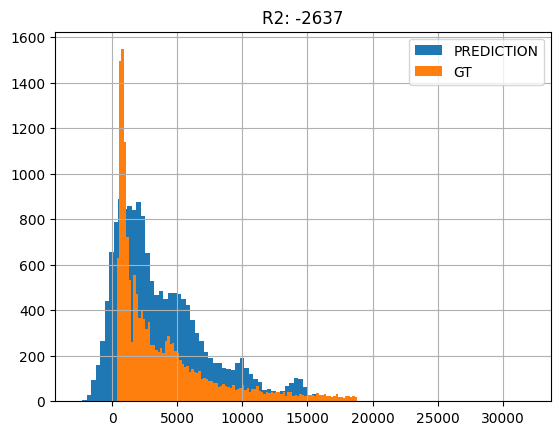

In [ ]:
plt.title(f'R2: {str(score_mlp)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid()

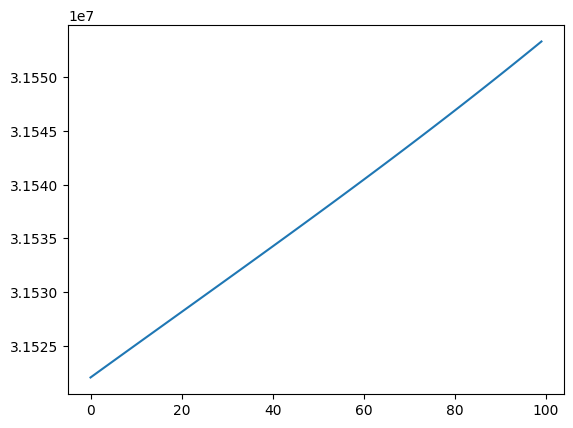

In [ ]:
plt.plot(losses_mlp)
plt.show()

In [ ]:
print(losses_mlp)
losses_mlp[-1]

[31522083.60756697, 31522389.4970181, 31522695.1347057, 31523000.534271214, 31523305.709365398, 31523610.673647843, 31523915.44078645, 31524220.024456937, 31524524.438342355, 31524828.696132634, 31525132.811524086, 31525436.798218958, 31525740.66992498, 31526044.440354902, 31526348.1232261, 31526651.732260045, 31526955.28118194, 31527258.783720285, 31527562.253606405, 31527865.704574075, 31528169.150359046, 31528472.604698665, 31528776.08133143, 31529079.593996566, 31529383.15643362, 31529686.782381997, 31529990.485580593, 31530294.279767323, 31530598.17867869, 31530902.196049385, 31531206.345611818, 31531510.64109568, 31531815.09622751, 31532119.72473023, 31532424.54032269, 31532729.556719206, 31533034.787629068, 31533340.24675608, 31533645.94779808, 31533951.904446404, 31534258.130385417, 31534564.63929195, 31534871.444834843, 31535178.56067434, 31535486.000461545, 31535793.777837902, 31536101.906434588, 31536410.399871927, 31536719.271758776, 31537028.53569194, 31537338.205255512, 3

31553286.07969066